In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.ensemble import RandomForestClassifier
from PIL import UnidentifiedImageError
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score, precision_score, recall_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3, DenseNet121, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet

Extracting features using mobilenetv2 model...
1/1 [==============================] - 0s 54ms/step
Sample image from valid/tangan:


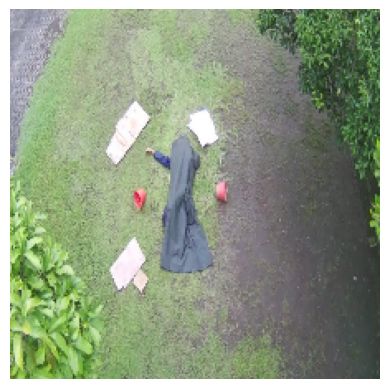

1/1 [==============================] - 0s 77ms/step
Sample image from test/tangan:


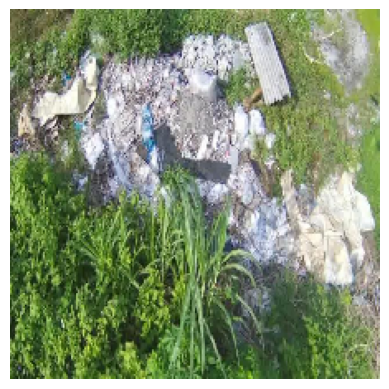

1/1 [==============================] - 0s 47ms/step


In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
base_dir = '/content/drive/My Drive/victim detection 4 classes'
datasets = ['train', 'valid', 'test']
def preprocess_mobilenetv2(img):
    return preprocess_input(img)
img_size=(224,224)
models = {
    'mobilenetv2': (MobileNetV2(weights='imagenet', include_top=False, pooling='avg'), preprocess_mobilenetv2, img_size)
}

# Extract features for each dataset using MobileNetV2
for model_name, (model, preprocess_func, img_size) in models.items():
    print(f"Extracting features using {model_name} model...")
    for dataset in datasets:
        extract_features(base_dir, dataset, model, preprocess_func, img_size, model_name)


In [5]:
def load_and_preprocess_image(img_path, img_size, preprocess_func):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)
    return img, img_array

def extract_features(data_dir, dataset, model, preprocess_func, img_size, model_name):
    data = []
    labels = []
    target_classes = ['utuh', 'kaki', 'kepala', 'tangan']  # Define target classes
    for i, img_name in enumerate(os.listdir(os.path.join(data_dir, dataset))):
        img_path = os.path.join(data_dir, dataset, img_name)
        # Extract class label from the filename
        class_label = img_name.split('-')[0]
        if class_label in target_classes:  # Check if class is in target classes
            try:
                img, img_array = load_and_preprocess_image(img_path, img_size, preprocess_func)

                # Print a sample image
                if i == 0:  # Print the first image
                    print(f"Sample image from {dataset}/{class_label}:")
                    plt.imshow(image.array_to_img(img_array[0]))
                    plt.axis('off')
                    plt.show()

                features = model.predict(img_array)
                features = features.flatten()
                data.append(features)
                labels.append(class_label)
            except UnidentifiedImageError:
                print(f"Skipping file {img_name}: not a valid image.")

    df = pd.DataFrame(data)
    df['label'] = labels
    df.to_csv(f'{dataset}_features_{model_name}.csv', index=False)


In [8]:
import pandas as pd

# Load extracted features
train_df_mobilenetv2 = pd.read_csv('train_features_mobilenetv2.csv')
validation_df_mobilenetv2 = pd.read_csv('valid_features_mobilenetv2.csv')
test_df_mobilenetv2 = pd.read_csv('test_features_mobilenetv2.csv')

# Separate features and labels for MobileNetV2
X_train_mobilenetv2 = train_df_mobilenetv2.drop('label', axis=1)
y_train_mobilenetv2 = train_df_mobilenetv2['label']
X_validation_mobilenetv2 = validation_df_mobilenetv2.drop('label', axis=1)
y_validation_mobilenetv2 = validation_df_mobilenetv2['label']
X_test_mobilenetv2 = test_df_mobilenetv2.drop('label', axis=1)
y_test_mobilenetv2 = test_df_mobilenetv2['label']

In [9]:
from sklearn.ensemble import RandomForestClassifier
from time import time

# Initialize the RandomForestClassifier for MobileNetV2 features
rf_classifier_mobilenetv2 = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
start_time = time()
rf_classifier_mobilenetv2.fit(X_train_mobilenetv2, y_train_mobilenetv2)
end_time = time()

# Calculate training time for MobileNetV2 features
training_time_mobilenetv2 = end_time - start_time


In [10]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the validation data using ResNet features
y_val_pred_mobilenetv2 = rf_classifier_mobilenetv2.predict(X_validation_mobilenetv2)

# Evaluate the model on validation data
print("Validation Accuracy (MobileNetV2):", accuracy_score(y_validation_mobilenetv2, y_val_pred_mobilenetv2))
print("Validation Classification Report (MobileNetV2):")
print(classification_report(y_validation_mobilenetv2, y_val_pred_mobilenetv2))

# Predict on the test data using ResNet features
y_test_pred_mobilenetv2 = rf_classifier_mobilenetv2.predict(X_test_mobilenetv2)

# Evaluate the model on test data
print("Test Accuracy (MobileNetV2):", accuracy_score(y_test_mobilenetv2, y_test_pred_mobilenetv2))
print("Test Classification Report (MobileNetV2):")
print(classification_report(y_test_mobilenetv2, y_test_pred_mobilenetv2))


Validation Accuracy (MobileNetV2): 0.9730769230769231
Validation Classification Report (MobileNetV2):
              precision    recall  f1-score   support

        kaki       0.95      0.99      0.97        74
      kepala       0.99      0.96      0.97        70
      tangan       0.97      0.98      0.98        61
        utuh       1.00      0.96      0.98        55

    accuracy                           0.97       260
   macro avg       0.98      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260

Test Accuracy (MobileNetV2): 0.976
Test Classification Report (MobileNetV2):
              precision    recall  f1-score   support

        kaki       0.96      1.00      0.98        27
      kepala       0.97      0.97      0.97        32
      tangan       0.97      0.97      0.97        29
        utuh       1.00      0.97      0.99        37

    accuracy                           0.98       125
   macro avg       0.97      0.98      0.98       125
weight

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Helper function to calculate Intersection over Union (IoU)
def calculate_iou(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    intersection = np.diag(cm)
    ground_truth_set = cm.sum(axis=1)
    predicted_set = cm.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    iou = intersection / union.astype(np.float32)
    return np.mean(iou)

# Helper function to calculate AUC
def calculate_auc(y_true, y_pred):
    y_true_bin = label_binarize(y_true, classes=['utuh', 'kaki', 'kepala', 'tangan'])
    y_pred_bin = label_binarize(y_pred, classes=['utuh', 'kaki', 'kepala', 'tangan'])
    return roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')

# Predict on the validation data
y_val_pred_mobilenetv2 = rf_classifier_mobilenetv2.predict(X_validation_mobilenetv2)

# Predict on the test data
y_test_pred_mobilenetv2 = rf_classifier_mobilenetv2.predict(X_test_mobilenetv2)

# Evaluate the model
metrics = {
    'Accuracy': accuracy_score,
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
    'F1 Score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    'IoU': calculate_iou,
    'AUC': calculate_auc
}

# Validation Metrics
print("Validation Metrics (MobileNetV2):")
for metric_name, metric_func in metrics.items():
    print(f"{metric_name}: {metric_func(y_validation_mobilenetv2, y_val_pred_mobilenetv2):.4f}")

# Test Metrics
print("\nTest Metrics (MobileNetV2):")
for metric_name, metric_func in metrics.items():
    print(f"{metric_name}: {metric_func(y_test_mobilenetv2, y_test_pred_mobilenetv2):.4f}")

# Print classification report for detailed class-wise metrics
print("\nValidation Classification Report (MobileNetV2):")
print(classification_report(y_validation_mobilenetv2, y_val_pred_mobilenetv2))

print("\nTest Classification Report (MobileNetV2):")
print(classification_report(y_test_mobilenetv2, y_test_pred_mobilenetv2))

# FPS (Frames Per Second)
fps_mobilenetv2 = len(X_test_mobilenetv2) / training_time_mobilenetv2
print(f"\nTraining Time (MobileNetV2): {training_time_mobilenetv2:.4f} seconds")
print(f"Frames Per Second (FPS) (MobileNetV2): {fps_mobilenetv2:.2f}")


Validation Metrics (MobileNetV2):
Accuracy: 0.9731
Precision: 0.9753
Recall: 0.9727
F1 Score: 0.9737
IoU: 0.9489
AUC: 0.9818

Test Metrics (MobileNetV2):
Accuracy: 0.9760
Precision: 0.9746
Recall: 0.9768
F1 Score: 0.9756
IoU: 0.9525
AUC: 0.9845

Validation Classification Report (MobileNetV2):
              precision    recall  f1-score   support

        kaki       0.95      0.99      0.97        74
      kepala       0.99      0.96      0.97        70
      tangan       0.97      0.98      0.98        61
        utuh       1.00      0.96      0.98        55

    accuracy                           0.97       260
   macro avg       0.98      0.97      0.97       260
weighted avg       0.97      0.97      0.97       260


Test Classification Report (MobileNetV2):
              precision    recall  f1-score   support

        kaki       0.96      1.00      0.98        27
      kepala       0.97      0.97      0.97        32
      tangan       0.97      0.97      0.97        29
        utu